<a href="https://colab.research.google.com/github/urieliram/statistical/blob/main/Tarea9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install pygam

In [9]:
import pandas as pd        
from pygam import LogisticGAM
from sklearn.datasets import load_breast_cancer
from matplotlib import pyplot as plt

In [10]:
#load the breast cancer data set
data = load_breast_cancer()
#keep first 6 features only
df = pd.DataFrame(data.data, columns=data.feature_names)[['mean radius', 'mean texture', 'mean perimeter', 'mean area','mean smoothness', 'mean compactness']]
target_df = pd.Series(data.target)
df.describe()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400


In [11]:
X = df[['mean radius', 'mean texture', 'mean perimeter', 'mean area','mean smoothness', 'mean compactness']]
y = target_df
#Fit a model with the default parameters
gam = LogisticGAM().fit(X, y)

In [12]:
gam.summary()

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                     19.4476
Link Function:                        LogitLink Log Likelihood:                                   -54.0256
Number of Samples:                          569 AIC:                                              146.9464
                                                AICc:                                             148.5483
                                                UBRE:                                               2.2856
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.8562
Feature Function                  Lam

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  """Entry point for launching an IPython kernel.


In [13]:
gam.accuracy(X, y)

0.9560632688927944

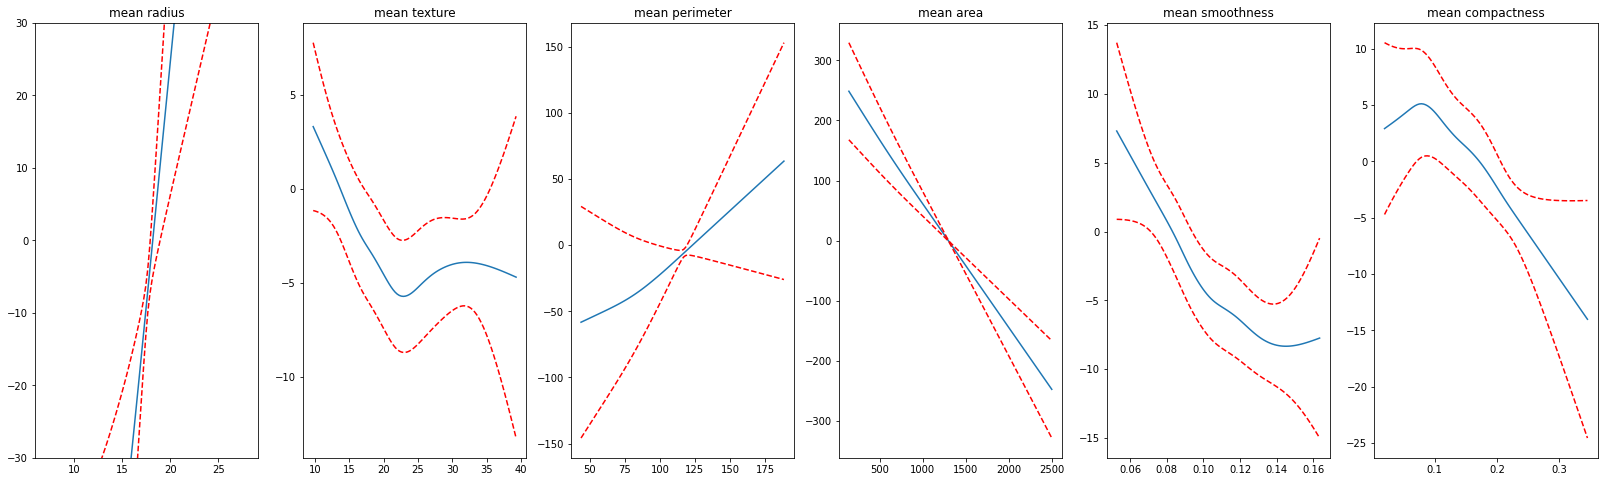

In [21]:
plt.rcParams['figure.figsize'] = (28, 8)
fig, axs = plt.subplots(1, len(data.feature_names[0:6]))
titles = data.feature_names
for i, ax in enumerate(axs):
    XX = gam.generate_X_grid(term=i)
    XX = gam.generate_X_grid(term=i)
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX))
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX,   width=.95)[1], c='r', ls='--')
    ax.set_title(titles[i])
    if i == 0:
        ax.set_ylim(-30,30)
        ax.set_title(titles[i])
plt.show()

[A Tour of pyGAM](https://pygam.readthedocs.io/en/latest/notebooks/tour_of_pygam.html)

[A example of pyGAM](https://codeburst.io/pygam-getting-started-with-generalized-additive-models-in-python-457df5b4705f)

[documentación pyGAM](https://pygam.readthedocs.io/en/latest/)

[pyGAM : Getting Started with Generalized Additive Models in Python](https://codeburst.io/pygam-getting-started-with-generalized-additive-models-in-python-457df5b4705f)

[Building interpretable models with Generalized additive models in Python](https://medium.com/just-another-data-scientist/building-interpretable-models-with-generalized-additive-models-in-python-c4404eaf5515)